# llc4320 spectra: Eulerian

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from cmocean import cm
import dask.dataframe as dd
from xhistogram.xarray import histogram

%matplotlib inline
from matplotlib import pyplot as plt
import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.6417856.datarmor0/parcels-502027/libparcels_random_5cad9d21-ca07-4523-8957-f3cbb0f2f994.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster(cores=6, processes=12) # necessary?
    w = cluster.scale(jobs=18)
    # 3 needed for lagrangian lon/lat binning
    # 15 for eulerian binning
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Client Scheduler: tcp://10.148.1.34:45478 Dashboard: http://10.148.1.34:8787/status,Cluster Workers: 180 Cores: 720 Memory: 1.64 TiB


In [3]:
client

Client Scheduler: tcp://10.148.1.34:40631 Dashboard: http://10.148.1.34:8787/status,Cluster Workers: 112 Cores: 112 Memory: 1.75 TiB


_________
# Eulerian spectra
### last update: 2021.08.23

In [ ]:
E = '/home/datawork-lops-osi/equinox/mit4320/diags'

---
## 1. lat x lon binned spectra (i.e. 2D spectra)

In [4]:
V = ["SSUV","SST","Eta"]
T = ["T30", "T60", "T30_nomean", "T60_nomean"]

#V = ["SSUV"]
#T = ["T60"]

sub = 8
dl = 1.
lon = np.arange(-180.,180., dl)
lat = np.arange(-60., 60., dl)
    
for v in V:
    for t in T:
        
        # read data
        ds = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/spectra_%s_%s.zarr'%(v,t)))
        ds = ds.isel(i=slice(0,None,sub),j=slice(0,None,sub))
        ds = ds.where(ds.Depth>500, drop=False)
        #ds = ds.load()
        
        # lat, lon binning
        ds['lon'] = 0*ds.face+ds.XC
        ds['lat'] = 0*ds.face+ds.YC
        N = histogram(
                      ds.lon.load(), ds.lat.load(), 
                      bins=[lon, lat], 
                      dim=['i', 'j', 'face'], 
                      block_size=None
                     )
        
        # compute histogram with weights
        ds['lon'] = 0*ds[v]+ds.XC
        ds['lat'] = 0*ds[v]+ds.YC

        E = histogram(
                      ds.lon.load(), ds.lat.load(),
                      bins=[lon, lat], 
                      weights= ds[v].load(), 
                      dim=['i', 'j', 'face'], 
                      block_size=None
                     )
        
        # get binned results
        E = (E/N).rename('E_%s'%(v)).rename({'freq_time':'frequency', 'lon_bin':'lon_bins', 'lat_bin':'lat_bins'})        
        E = E.where(E>0)
        # save
        E.to_dataset().to_zarr(os.path.join(ut.root_data_dir,'diags/%s_%s_lat_lon.zarr'%(v,t)), mode='w')
        print('<%s_%s - allready processed>'%(v,t))                    

<SSUV_T30 - allready processed>
<SSUV_T60 - allready processed>
<SSUV_T30_nomean - allready processed>
<SSUV_T60_nomean - allready processed>
<SST_T30 - allready processed>
<SST_T60 - allready processed>
<SST_T30_nomean - allready processed>
<SST_T60_nomean - allready processed>
<Eta_T30 - allready processed>
<Eta_T60 - allready processed>
<Eta_T30_nomean - allready processed>
<Eta_T60_nomean - allready processed>


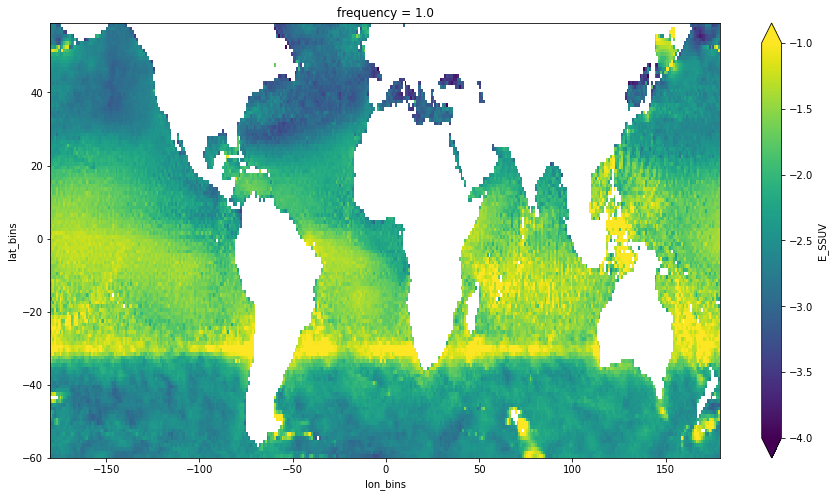

In [5]:
# load
E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_lat_lon.zarr'))
fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(E.E_SSUV).sel(frequency=1).plot(x='lon_bins',y='lat_bins',vmin=-4,vmax=-1)

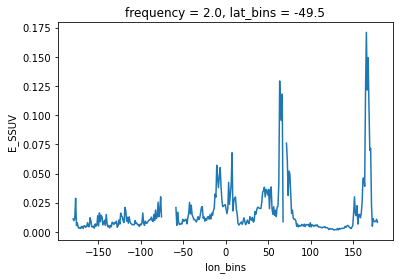

In [9]:
E.E_SSUV.sel(frequency=2).isel(lat_bins=10).plot()

____________
## 2. Zonal averaging

In [45]:
V = ["SSUV","SST","Eta"]
T = ["T30", "T60", "T30_nomean", "T60_nomean"]
sub = 2
dl = 1.
lat_bins = np.arange(-60, 60, dl)
    
for v in V:
    for t in T:

        ds = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/spectra_%s_%s.zarr'%(v,t)))
        ds = ds.isel(i=slice(0,None,sub),j=slice(0,None,sub))
        ds = ds.where(ds.Depth>500, drop=False)
        ds['lat3'] = 0*ds.face+ds.YC
        ds['lat4'] = 0*ds[v]+ds.YC
        #ds = ds.persist()
        N = histogram(ds.lat3.rename('lat').where(ds.Depth>500), bins=[lat_bins], 
                      dim=['i', 'j', 'face']
                     ).persist()

        E = histogram(ds.lat4.rename('lat').where(ds.Depth>500), bins=[lat_bins], 
                      weights=ds[v], 
                      dim=['i', 'j', 'face']
                     )

        E = (E/N).rename('E_%s_%s'%(v,t)).persist()
        E = E.rename({'freq_time': 'frequency', 'lat_bin':'lat_bins'})   
        E.to_dataset().to_zarr(os.path.join(ut.root_data_dir,'diags/%s_%s_lat.zarr'%(v,t)), mode='w')
        print('<%s_%s - allready processed>'%(v,t))        

<SSUV_T30 - allready processed>
<SSUV_T60 - allready processed>
<SSUV_T30_nomean - allready processed>
<SSUV_T60_nomean - allready processed>
<SST_T30 - allready processed>
<SST_T60 - allready processed>
<SST_T30_nomean - allready processed>
<SST_T60_nomean - allready processed>
<Eta_T30 - allready processed>
<Eta_T60 - allready processed>
<Eta_T30_nomean - allready processed>
<Eta_T60_nomean - allready processed>


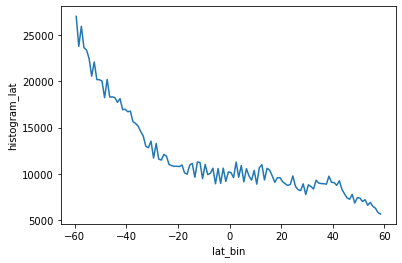

In [43]:
N.plot()

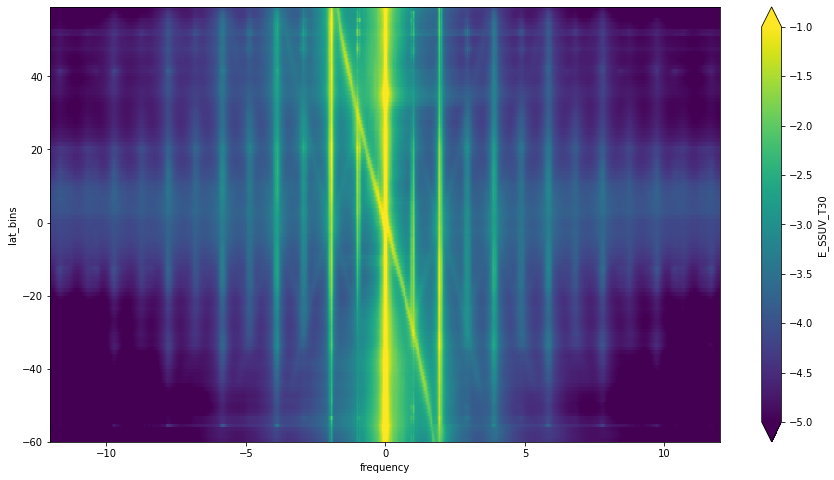

In [46]:
# load
E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T30_lat.zarr'))
fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(E.E_SSUV_T30).plot(x='frequency',vmin=-5,vmax=-1)

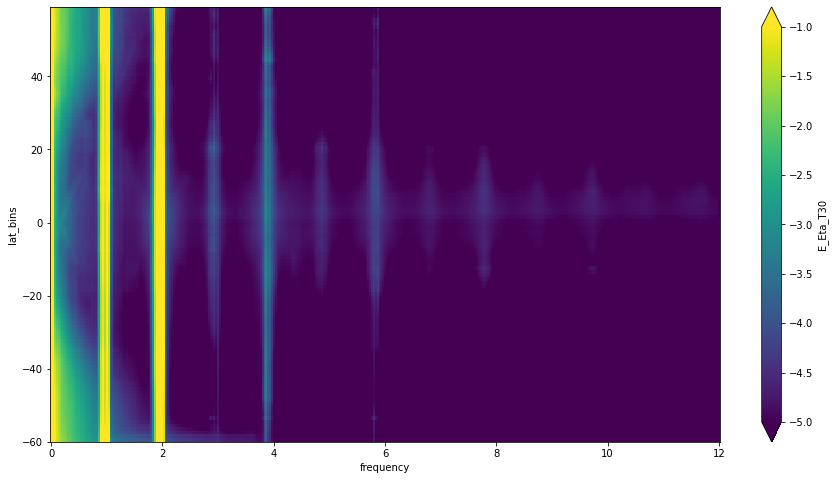

In [47]:
# load
E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/Eta_T30_lat.zarr'))
fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(E.E_Eta_T30).plot(x='frequency',vmin=-5,vmax=-1)

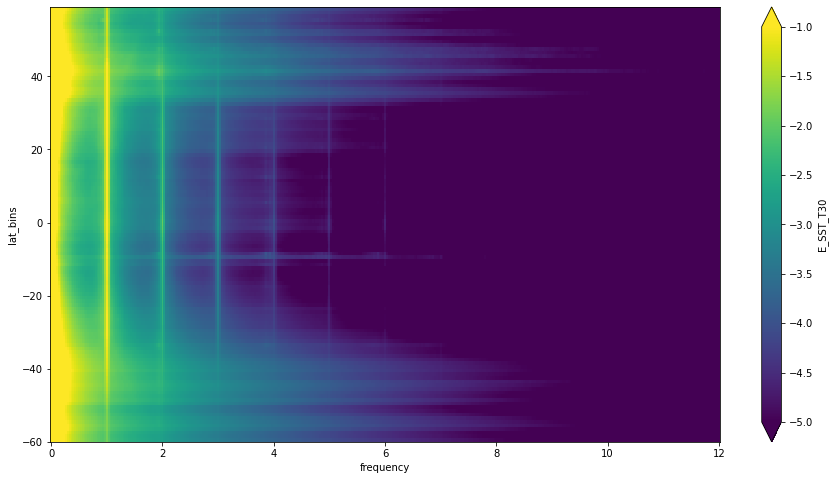

In [48]:
# load
E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SST_T30_lat.zarr'))
fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(E.E_SST_T30).plot(x='frequency',vmin=-5,vmax=-1)

_____________
## 3. lon x lat for band-integrated KE

## Method 1

In [61]:
ds

<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1440, i: 270, j: 270)
Coordinates:
    Depth      (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    XC         (face, j, i) float32 -114.9 -114.9 -114.9 ... -110.8 -113.0
    YC         (face, j, i) float32 -88.18 -88.22 -88.27 ... -88.13 -88.13
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * i          (i) int64 0 16 32 48 64 80 96 ... 4224 4240 4256 4272 4288 4304
  * j          (j) int64 0 16 32 48 64 80 96 ... 4224 4240 4256 4272 4288 4304
    mask       (face, j, i) bool True True True True ... True True True True
Data variables:
    SSUV       (face, j, i, freq_time) float64 nan nan nan nan ... nan nan nan

In [ ]:
# From raw spectra

V = ["SSUV", "Eta", "SST"]
T = ["T30", "T60", "T30_nomean", "T60_nomean"]

V = ["SSUV"]
T = ["T60"]

sub = 4
dl = 2.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-60, 60, dl)

bands = {'total': (0., 12), 'low': (0., .5), 
         'diurnal_0dot1': (0.9, 1.1), 'diurnal_0dot2': (0.8, 1.2), 'diurnal_0dot3': (0.7, 1.3), 'diurnal_0dot4': (0.6, 1.4),
         'semidiurnal_0dot1': (1.9, 2.1), 'semidiurnal_0dot2': (1.8, 2.2), 'semidiurnal_0dot3': (1.7, 2.3), 'semidiurnal_0dot4': (1.6, 2.4),
         'inertial_0dot1':(0,0),'inertial_0dot2':(0,0),'inertial_0dot3':(0,0),'inertial_0dot4':(0,0)
        }

for v in V:
    for t in T:

        # load spectra
        ds = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/spectra_%s_%s.zarr'%(v,t)))
        ds = ds.isel(i=slice(0,None,sub),j=slice(0,None,sub))
        ds = ds.where(ds.Depth>500, drop=False)
        ds = ds.load()
        
        # define delta omega, Near-inertial f
        domega = float(ds.freq_time[1]- ds.freq_time[0])
        f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(ds['YC']))
        f_cpd_llc = f_llc*86400/2./np.pi
        
        # binning
        ds['lon'] = 0*ds.face+ds.XC
        ds['lat'] = 0*ds.face+ds.YC
        
        N = histogram(
                      ds.lon.rename('lon').load(), ds.lat.rename('lat').load(), 
                      bins=[lon_bins, lat_bins], 
                      dim=['i', 'j', 'face'], 
                      block_size=None
                     )
 
        # band integral
        Eb = {}
        for b, bounds in bands.items():
            #print('Frequency band {}, frequency bounds: {}-{} cpd'.format(b, bounds[0], bounds[1]))

            if b == "inertial_0dot1":
                _E = ds[v].where((np.abs(ds.freq_time + f_cpd_llc)<=0.1), 
                                  drop=False,
                                )

            elif b == "inertial_0dot2":
                _E = ds[v].where((np.abs(ds.freq_time + f_cpd_llc)<=0.2), 
                                  drop=False,
                                )

            elif b == "inertial_0dot3":
                _E = ds[v].where((np.abs(ds.freq_time + f_cpd_llc)<=0.3), 
                                  drop=False,
                                )                
                
            elif b == "inertial_0dot4":
                _E = ds[v].where((np.abs(ds.freq_time + f_cpd_llc)<=0.4), 
                                  drop=False,
                                )
                
            else:      
                _E = ds[v].where((np.abs(ds.freq_time)>=bounds[0]) & (np.abs(ds.freq_time)<=bounds[1]), 
                                  drop=False,
                                )
            _E = (domega*_E.sum('freq_time'))            

            E = histogram(
                          ds.lon.rename('lon').load(), ds.lat.rename('lat').load(),
                          bins=[lon_bins, lat_bins], 
                          weights=_E.load(),
                          dim=['i', 'j', 'face'], 
                          block_size=None
                         )

            E = (E/N).rename('E_%s'%(v))   
            Eb[b] = E.persist()

        # converts to single dataset and store:
        E = xr.concat(list(Eb.values()), 
                      dim=pd.Index(list(Eb.keys()),name='frequency_band'),
                     )
        E = E.where(E>0)
        
        E.to_dataset().to_zarr(os.path.join(ut.root_data_dir,'diags/%s_%s_lat_lon_bands_2deg.zarr'%(v,t)), mode='w')
        print('<%s_%s - allready processed>'%(v,t))        

## Method 2

In [55]:
# From 2D binned spectra (much quicker)

V = ["SSUV", "Eta", "SST"]
T = ["T30", "T60", "T30_nomean", "T60_nomean"]

lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-60, 60, dl)

bands = {'total': (0., 12), 'low': (0., .5), 
         'diurnal_0dot1': (0.9, 1.1), 'diurnal_0dot2': (0.8, 1.2), 'diurnal_0dot3': (0.7, 1.3), 'diurnal_0dot4': (0.6, 1.4),
         'semidiurnal_0dot1': (1.9, 2.1), 'semidiurnal_0dot2': (1.8, 2.2), 'semidiurnal_0dot3': (1.7, 2.3), 'semidiurnal_0dot4': (1.6, 2.4),
         'inertial_0dot1':(0,0),'inertial_0dot2':(0,0),'inertial_0dot3':(0,0),'inertial_0dot4':(0,0)
        }

for v in V:
    for t in T:

        # load 2d binned spectra
        ds = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/%s_%s_lat_lon.zarr'%(v,t)))
      
        # define delta omega, Near-inertial f
        domega = float(ds.frequency[1]- ds.frequency[0])
        f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(ds['lat_bins']))
        f_cpd_llc = f_llc*86400/2./np.pi
        
 
        # band integral
        Eb = {}
        for b, bounds in bands.items():
            #print('Frequency band {}, frequency bounds: {}-{} cpd'.format(b, bounds[0], bounds[1]))

            if b == "inertial_0dot1":
                _E = ds['E_'+v].where((np.abs(ds.frequency + f_cpd_llc)<=0.1), 
                                  drop=False,
                                )

            elif b == "inertial_0dot2":
                _E = ds['E_'+v].where((np.abs(ds.frequency + f_cpd_llc)<=0.2), 
                                  drop=False,
                                )

            elif b == "inertial_0dot3":
                _E = ds['E_'+v].where((np.abs(ds.frequency + f_cpd_llc)<=0.3), 
                                  drop=False,
                                )                
                
            elif b == "inertial_0dot4":
                _E = ds['E_'+v].where((np.abs(ds.frequency + f_cpd_llc)<=0.4), 
                                  drop=False,
                                )
                
            else:      
                _E = ds['E_'+v].where((np.abs(ds.frequency)>=bounds[0]) & (np.abs(ds.frequency)<=bounds[1]), 
                                  drop=False,
                                )

            E = domega * _E.sum('frequency')    
            Eb[b] = E.persist()

        # converts to single dataset and store:
        E = xr.concat(list(Eb.values()), 
                      dim=pd.Index(list(Eb.keys()),name='frequency_band'),
                     )
        
        E = E.where(E>0)
        
        E.to_dataset().to_zarr(os.path.join(ut.root_data_dir,'diags/%s_%s_lat_lon_bands_from_2Dbin_spectra.zarr'%(v,t)), mode='w')
        print('<%s_%s - allready processed>'%(v,t))        

<SSUV_T30 - allready processed>
<SSUV_T60 - allready processed>
<SSUV_T30_nomean - allready processed>
<SSUV_T60_nomean - allready processed>
<Eta_T30 - allready processed>
<Eta_T60 - allready processed>
<Eta_T30_nomean - allready processed>
<Eta_T60_nomean - allready processed>
<SST_T30 - allready processed>
<SST_T60 - allready processed>
<SST_T30_nomean - allready processed>
<SST_T60_nomean - allready processed>


In [56]:
# load
E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_lat_lon_bands_from_2Dbin_spectra.zarr'))
E

<xarray.Dataset>
Dimensions:         (frequency_band: 14, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
Data variables:
    E_SSUV          (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(1, 45, 30), meta=np.ndarray>

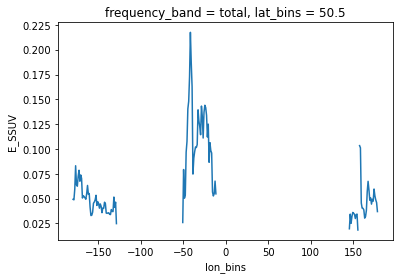

In [57]:
E.E_SSUV.sel(frequency_band='total').isel(lat_bins=110).plot()

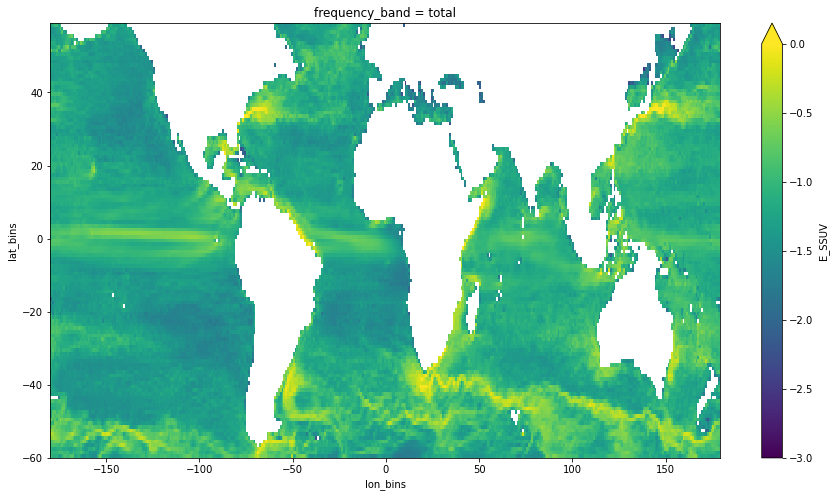

In [59]:
fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(E.E_SSUV).sel(frequency_band='total').plot(x='lon_bins',y='lat_bins',vmin=-3,vmax=0)

## Close cluster

In [ ]:
cluster.close()